In [3]:
pip install pygame

In [1]:
import sys
sys.path.append('C:/Users/Gabriel/GitHub/bloqueios')

import newBlock as nb
import cartopy
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import metpy.calc as mpcalc
import json
import calendar
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

import matplotlib.ticker as mticker
import matplotlib.font_manager as font_manager
import matplotlib.patches as mpatches
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import num2date
import matplotlib.pyplot as plt
import pygame

In [38]:
dataset = nb.dataset('D:/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/Climatologias/nc/msl_79_20.nc', 'ERA-5')
dados = (dataset.formatar(lat=[-20, -40], lon=[-42, 12], time=["1979-12-01", "2019-11-01"], opr="divisão", fator=100)).dataset

In [40]:
def season_coords(ds, periodo):
    
    # Nesta função o dataset(ds) original é recortado para o período de análise e retorna uma LISTA DE DATASETS e UM DATASET
    # A lista 'data_list' retornada contém os datasets.season de cada intervalo de UM ANO dentro do RANGE do 'periodo de recorte'
    # EX:: ASSUMINDO QUE 'PERIODO' É [1979-12-01, 2010-11-01] <--> 'DATA_LIST[0]' retornará o dataset.season do intervalo de ..
    # ... (Continuando)... >> [1979-12-01 até 1980-11-01] <<< EQUIVALENTE AO INTERVALO UM ANO (DATA_LIST[0])
    # O dataset 'data_season' retornado é o dataset.season de TODO o RANGE do 'periodo de recorte'
    # Logo, o 'data_season' é a média.SEASON do intervalo completo do dataset recortado
    # EX:: ASSUMINDO QUE PERIODO >> [1979-12-01, 2010-11-01] << --> 'DATA_SEASON' retornará o dataset.season do PERIODO
    
    data = ds.sel(time=slice(periodo[0], periodo[1]))
    data_season = data.groupby("time.season").mean()
    data_list = []
    for i in range(0, len(data.time.values), 12):
        d_slice = data.isel(time=slice(i, i+12))
        d_season = d_slice.groupby("time.season").mean()
        data_list.append(d_season)
        
    return data_list, data_season

In [103]:
def season_scat(ax, ds, season, hems, periodo, periodobase=None, media_periodo=False, media_base=False, only_media=False):
    
    # Nesta função é plotado o gráfico de distribuição 'SCATTER_PLOT' dos pontos máximos de pressão gerados 
    # Função suporta até DOIS períodos para comparação --> periodobase = periodo opcional para a comparação (climatologias)
    # Os parâmetros 'periodo' e 'periodobase' plotam os pontos de máxima para os datasets.season (DATA_LIST) ...
    #... (Continuando)... retornados para seus respectivos intervalos de 'periodo' e 'periodobase', enquanto os ...
    #... (Continuando)... *KWARGS 'media_periodo' e 'media_base' plotam para o dataset.season (DATA_SEASON) from 'SEASON_COORDS' 
    # O parametro only_media é um *KWARG que permite ao usuário, caso TODOS os outros *kwargs sejam =! dos valores default ...
    #... (Continuando)..., ou seja << periodobase != NONE AND medias !=FALSE >>, plotar somente os valores (DATA_SEASON)
    
    
    # IMPORTANDO 'DATA_SEASON' E 'DATA_LIST' CORRESPONDENTES AO INTERVALOR 'PERIODO'
    seasons, seasons_mean = season_coords(ds, periodo)
    
    # LISTA COM AS LABELS DOS SCATTER POINTS
    handles = []
    
    # CUIDADO: --> 'summer' é o verão do hemisfério Norte (JJA) <-> inverno do hemisfério (SUL) 'inverno'
    if hems == "Sul":
        if season == "verão" or season =="ver":
            season_index = 0
        elif season == "inverno" or season == "inv":
            season_index = 1
        elif season == "outono" or season == "out":
            season_index = 2
        elif season == "primavera" or season == "pri":
            season_index = 3
            
    elif hems == "Norte":
        if season == "winter" or season == "win":
            season_index = 0
        elif season == "summer" or season == "sum":
            season_index = 1
        elif season == "spring" or season == "spr":
            season_index = 2
        elif season == "autumn" or season == "aut":
            season_index = 3
        
    if only_media == False: 
        
        # Média Sazonal para cada intervalos de um ano <-> MÚLTIPLOS scatter points (!!!)
        # Formatando o dataset para o recorte do valor máximo de 'msl', retornando seu VALOR e COORDS
        # Plotando os scatter points <-> pontos de máximo
        for data in seasons:
            max_mensal = data.isel(season=season_index)
            max_data = max_mensal.where(max_mensal==max_mensal.msl.max(), drop=True)
            latitude = np.nanmax(max_data.lat)
            longitude = np.mean(max_data.lon)
            valores, xs, ys = max_data.msl, longitude, latitude         
            ax.scatter(xs, ys, transform=ccrs.PlateCarree(), color='orangered', alpha=0.5)
        cyan_patch_1 = mpatches.Patch(color='orangered', label=f"{periodo[0][0:4]} to {periodo[1][0:4]}", capstyle="round")
        handles.append(cyan_patch_1)
        
    if media_periodo == True:
        
        # Média sazonal para o período completo <-> ÚNICO scatter point (!!!)
        # Formatando o dataset para o recorte do valor máximo de 'msl', retornando seu VALOR e COORDS
        # Plotando os scatter points <-> pontos de máximo
        max_season_mean = seasons_mean.isel(season=season_index)
        max_data_mean = max_season_mean.where(max_season_mean==max_season_mean.msl.max(), drop=True)
        latitude_mean = np.nanmax(max_data_mean.lat)
        longitude_mean = np.mean(max_data_mean.lon)
        valores, xs, ys = max_data_mean.msl, longitude_mean, latitude_mean  
        if only_media == False:
            ax.scatter(xs, ys, s=300, transform=ccrs.PlateCarree(), color='orangered', alpha=1, marker='v')
        else:
            ax.scatter(xs, ys, s=200, transform=ccrs.PlateCarree(), color='orangered', alpha=1, marker='x', label=f"{periodo[0][0:4]} to {periodo[1][0:4]}", capstyle="round")

    if periodobase != None:
        # IMPORTANDO 'DATA_SEASON' E 'DATA_LIST' CORRESPONDENTES AO INTERVALOR 'PERIODOBASE'
        seasons_2, seasons_mean_2 = season_coords(ds, periodobase)
        
        if only_media == False:
            # MESMOS RACIOCÍNIOS, AGORA APLICADOS PARA O SEGUNDO PERIODO DE COMPARAÇÃO (periodobase) != None
            for data in seasons_2:
                max_mensal_2 = data.isel(season=season_index)
                max_data_2 = max_mensal_2.where(max_mensal_2==max_mensal_2.msl.max(), drop=True)
                latitude_2 = np.nanmax(max_data_2.lat)
                longitude_2 = np.mean(max_data_2.lon)
                valores, xs, ys = max_data_2.msl, longitude_2, latitude_2         
                ax.scatter(xs, ys, transform=ccrs.PlateCarree(), color='darkcyan', alpha=0.5)
            cyan_patch_3 = mpatches.Patch(color='darkcyan', label=f"{periodobase[0][0:4]} to {periodobase[1][0:4]}", capstyle="round")
            handles.append(cyan_patch_3)
            
        if media_base == True:
            # MESMOS RACIOCÍNIOS, AGORA APLICADOS PARA O SEGUNDO PERIODO DE COMPARAÇÃO (periodobase) != None
            max_season_mean_2 = seasons_mean_2.isel(season=season_index)
            max_data_mean_2 = max_season_mean_2.where(max_season_mean_2==max_season_mean_2.msl.max(), drop=True)
            latitude_mean_2 = np.nanmax(max_data_mean_2.lat)
            longitude_mean_2 = np.mean(max_data_mean_2.lon)
            valores, xs, ys = max_data_mean_2.msl, longitude_mean_2, latitude_mean_2
            if only_media == False:
                ax.scatter(xs, ys, s=300, transform=ccrs.PlateCarree(), color='darkcyan', alpha=1, marker='v')
            else:
                ax.scatter(xs, ys, s=200, transform=ccrs.PlateCarree(), color='darkcyan', alpha=1, marker="x", label=f"{periodobase[0][0:4]} to {periodobase[1][0:4]}", capstyle="round")
   
    if only_media == True:
        # TÍTULO DA LEGENDA QUANDO HÁ SÓ OS VALORES DE 'DATA_SEASON' <-> 'ONLY_MEDIA == TRUE'
        ax.legend(title="Max Position", title_fontsize=12, loc="upper right", fancybox=True, shadow=True, labelspacing=1.0, borderpad=0.7)
    else:
        # SEM TÍTULO DE LEGENDA PARA 'ONLY_MEDIA == FALSE'
        ax.legend(handles=handles, prop=font_manager.FontProperties(style='oblique', size=12), loc="upper right", fancybox=True, shadow=True)
        
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='gray')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.ylines = True
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 200, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-180, 200, 5))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}

    ax.set_extent([-42, 12, -40, -20], crs=ccrs.PlateCarree())         
    ax.coastlines()
    ax.set_title(seasons_mean.season[season_index].values, loc='left', fontsize=20, style="oblique")
    ax.set_title("LAMMOC-UFF", loc='right', fontsize=9, style="oblique")
    

In [104]:
def figura(hems, periodo, periodobase=None, media_periodo=False, media_base=False, only_media=False):
    
    fig, ax = plt.subplots(ncols = 2, nrows = 2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(20, 10))
    fig.suptitle("Maximum Sea Level Pressure by Season", fontsize=30, fontstyle='oblique')
    
    if hems == "Sul":
        season_scat(ax[0,0], dados, "ver", hems, periodo, periodobase, media_periodo, media_base, only_media)
        season_scat(ax[0,1], dados, "inv", hems, periodo, periodobase, media_periodo, media_base, only_media)
        season_scat(ax[1,0], dados, "out", hems, periodo, periodobase, media_periodo, media_base, only_media)
        season_scat(ax[1,1], dados, "pri", hems, periodo, periodobase, media_periodo, media_base, only_media)
        
    if hems == "Norte":
        season_scat(ax[0,0], dados, "win", hems, periodo, periodobase, media_periodo, media_base, only_media)
        season_scat(ax[0,1], dados, "sum", hems, periodo, periodobase, media_periodo, media_base, only_media)
        season_scat(ax[1,0], dados, "spr", hems, periodo, periodobase, media_periodo, media_base, only_media)
        season_scat(ax[1,1], dados, "aut", hems, periodo, periodobase, media_periodo, media_base, only_media)

    # plt.savefig("MSL_MAX_Scatt_Mean.png")
    # plt.savefig("MSL_MAX_Mean.png")
    # plt.savefig("MSL_MAX_Scatt.png")


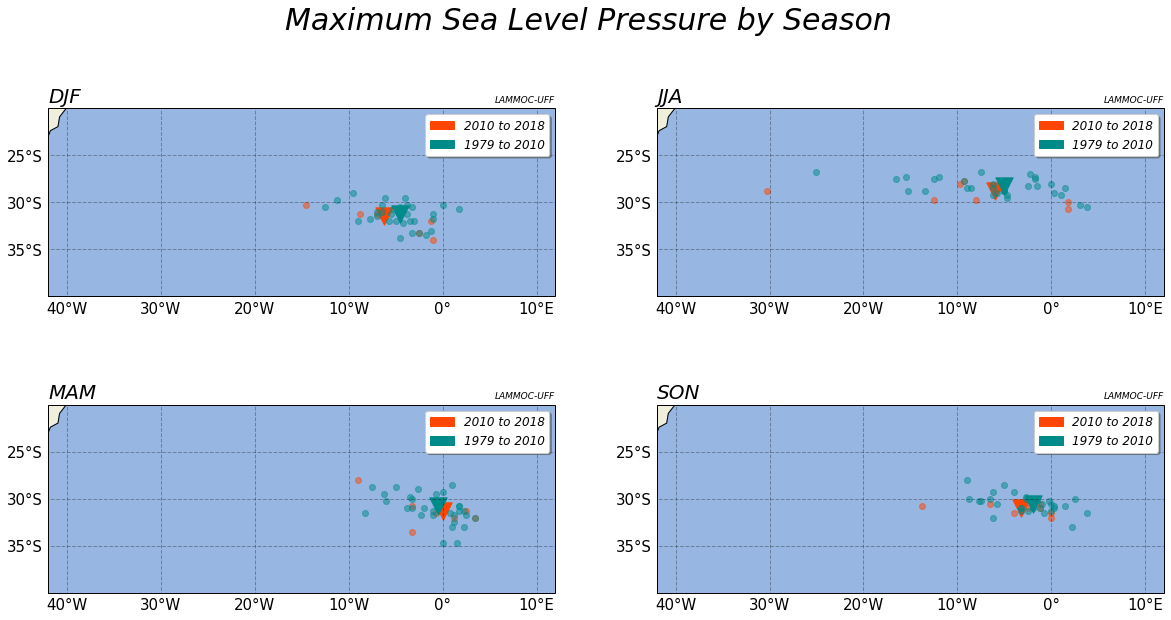

In [105]:
figura("Norte", ["2010-12-01", "2018-11-01"], ["1979-12-01", "2010-11-01"], media_periodo=True, media_base=True)

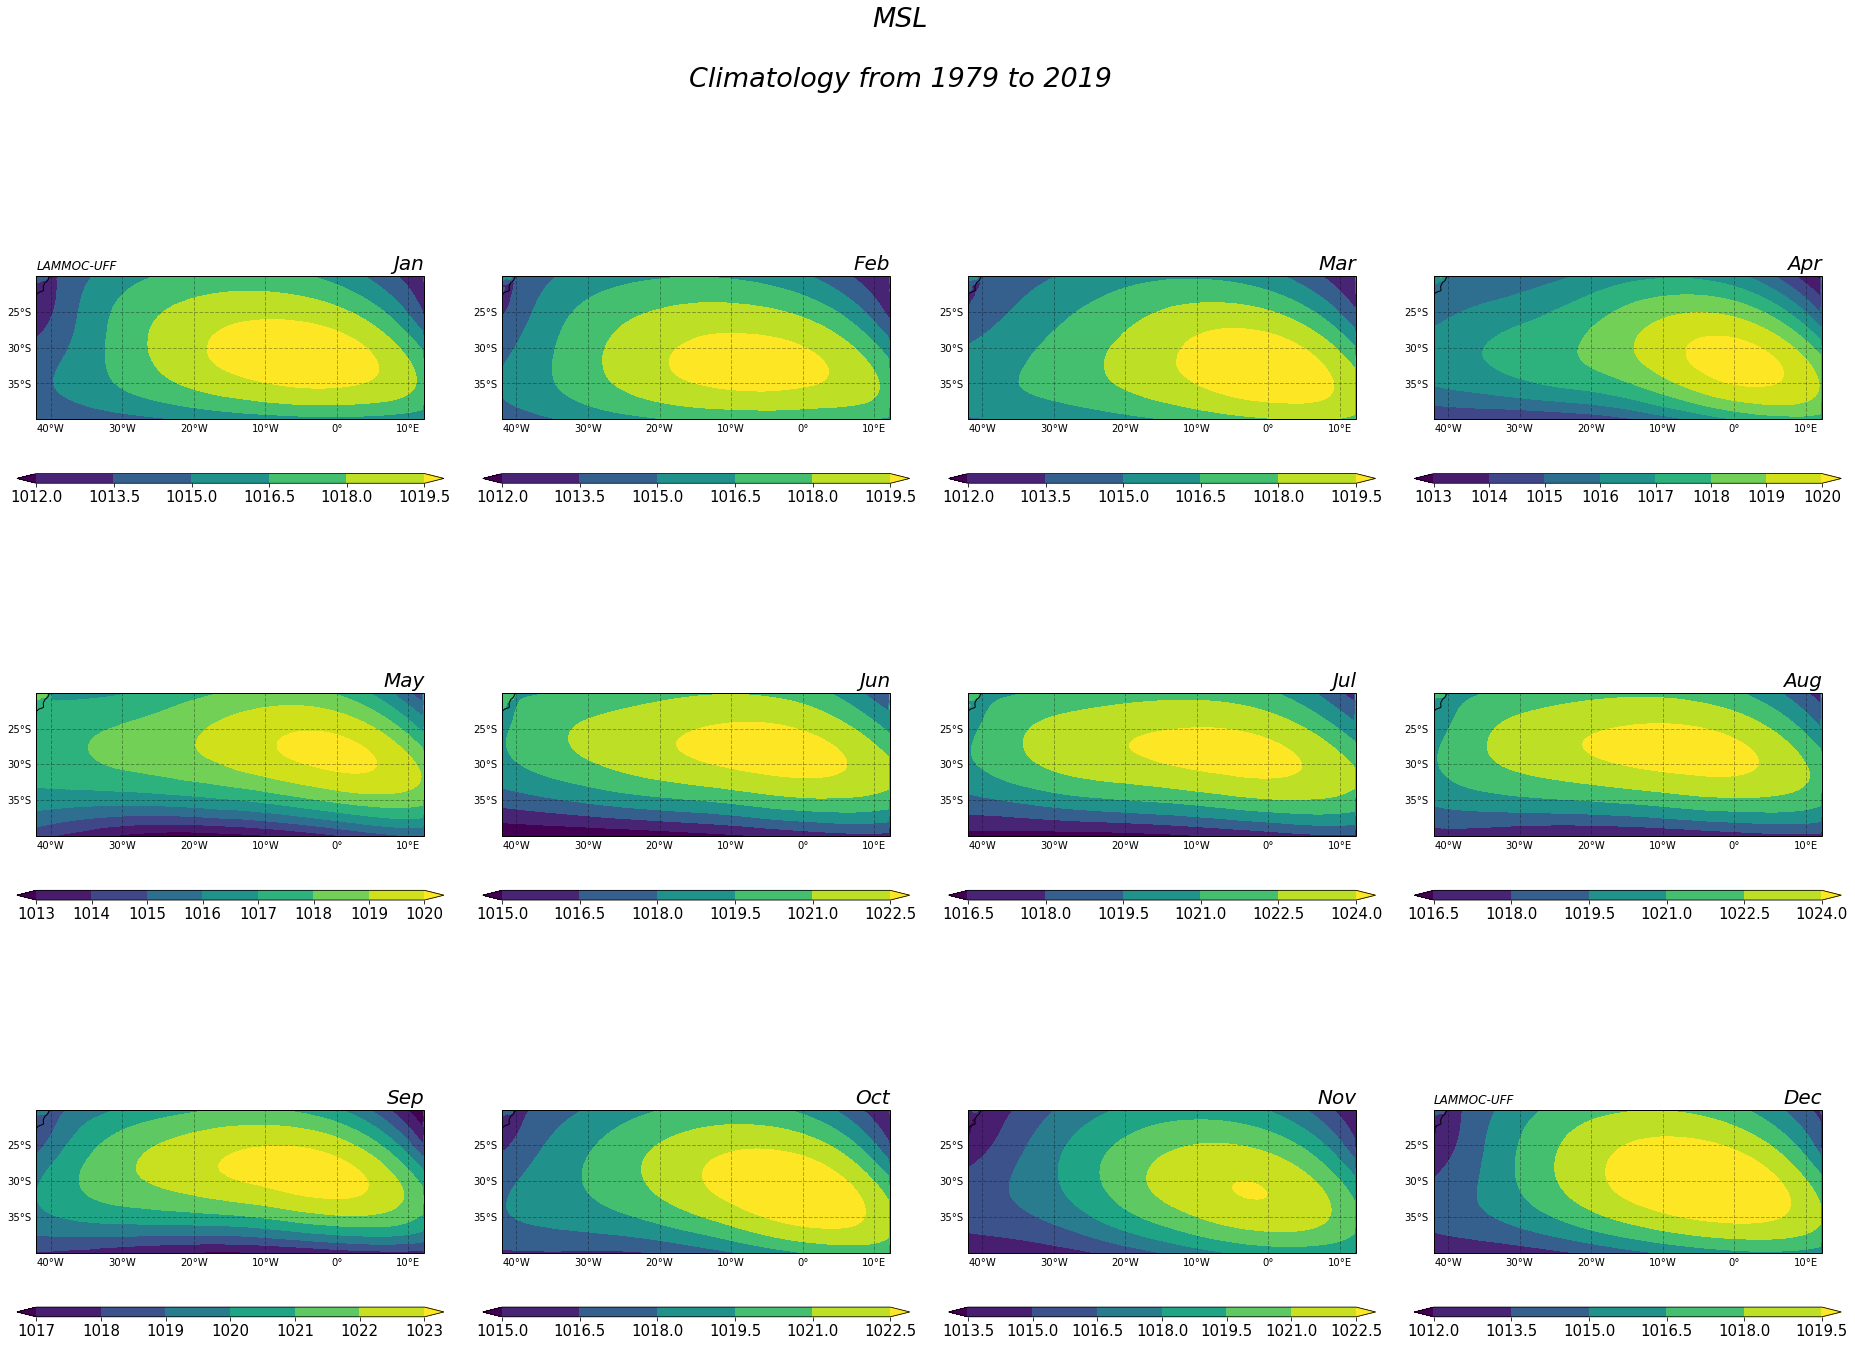

In [44]:
dataset.formatar(lat=[-20, -40], lon=[-42, 12], time=["1979-12-01", "2019-11-01"], opr="divisão", fator=100).climatologia().new_plot.multiplots(kind='climatologia',periodo=["1979-12-01", "2019-11-01"])

In [45]:
data_list, data_season = season_coords(dados, ["1979-12-01", "2019-11-01"])

In [46]:
data_season

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 217, season: 4)
Coordinates:
  * lon      (lon) float32 -42.0 -41.75 -41.5 -41.25 ... 11.25 11.5 11.75 12.0
  * lat      (lat) float32 -20.0 -20.25 -20.5 -20.75 ... -39.5 -39.75 -40.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    msl      (season, lat, lon) float32 1014.35516 1014.30853 ... 1018.4731

In [47]:
df = data_season.msl.to_dataframe()

In [48]:
df

msl
season lat   lon                
DJF    -20.0 -42.00  1014.355164
             -41.75  1014.308533
             -41.50  1014.159241
             -41.25  1014.394958
             -41.00  1014.569702
...                          ...
SON    -40.0  11.00  1018.597778
              11.25  1018.568298
              11.50  1018.540833
              11.75  1018.509949
              12.00  1018.473083

[70308 rows x 1 columns]

In [49]:
DF = df.where(df['msl']>=1018)
DF

msl
season lat   lon                
DJF    -20.0 -42.00          NaN
             -41.75          NaN
             -41.50          NaN
             -41.25          NaN
             -41.00          NaN
...                          ...
SON    -40.0  11.00  1018.597778
              11.25  1018.568298
              11.50  1018.540833
              11.75  1018.509949
              12.00  1018.473083

[70308 rows x 1 columns]

In [51]:
dataF = DF.dropna()
DJF =  dataF.loc['DJF']
JJA =  dataF.loc['JJA']
MAM =  dataF.loc['MAM']
SON =  dataF.loc['SON']
'''
DJF.to_csv('DJF.csv')
JJA.to_csv('JJA.csv')
MAM.to_csv('MAM.csv')
SON.to_csv('SON.csv')
'''

"\nDJF.to_csv('DJF.csv')\nJJA.to_csv('JJA.csv')\nMAM.to_csv('MAM.csv')\nSON.to_csv('SON.csv')\n"

In [52]:
dataF

msl
season lat    lon                
DJF    -22.25 -15.75  1018.007019
              -15.50  1018.014709
              -15.25  1018.025635
              -15.00  1018.035950
              -14.75  1018.043152
...                           ...
SON    -40.00  11.00  1018.597778
               11.25  1018.568298
               11.50  1018.540833
               11.75  1018.509949
               12.00  1018.473083

[44459 rows x 1 columns]

In [53]:
DataF = xr.Dataset.from_dataframe(dataF)
DataF

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 217, season: 4)
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lat      (lat) float64 -40.0 -39.75 -39.5 -39.25 ... -20.5 -20.25 -20.0
  * lon      (lon) float64 -42.0 -41.75 -41.5 -41.25 ... 11.25 11.5 11.75 12.0
Data variables:
    msl      (season, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [59]:
dataDJF = xr.Dataset.from_dataframe(DJF)
dataJJA = xr.Dataset.from_dataframe(JJA)
dataMAM = xr.Dataset.from_dataframe(MAM)
dataSON = xr.Dataset.from_dataframe(SON)

In [60]:
DJF_coords_min = [dataDJF.msl.lat.values.min(),dataDJF.msl.lon.values.min()]
DJF_coords_max = [dataDJF.msl.lat.values.max(),dataDJF.msl.lon.values.max()]

JJA_coords_min = [dataJJA.msl.lat.values.min(),dataJJA.msl.lon.values.min()]
JJA_coords_max = [dataJJA.msl.lat.values.max(),dataJJA.msl.lon.values.max()]

MAM_coords_min = [dataMAM.msl.lat.values.min(),dataMAM.msl.lon.values.min()]
MAM_coords_max = [dataMAM.msl.lat.values.max(),dataMAM.msl.lon.values.max()]

SON_coords_min = [dataSON.msl.lat.values.min(),dataSON.msl.lon.values.min()]
SON_coords_max = [dataSON.msl.lat.values.max(),dataSON.msl.lon.values.max()]

In [69]:
JJA_coords_min

[-39.25, -42.0]

#    rect = mpatches.Rectangle((-20,-30),40,30,linewidth=4,edgecolor='yellow',facecolor='None')
#   ax.add_patch(rect)

In [64]:
LPseason = nb.lammoc_plot(DataF, 'ERA-5')

LPseason.seasons(kind='climatologia', periodo = ["1979-12-01", "2019-11-01"])

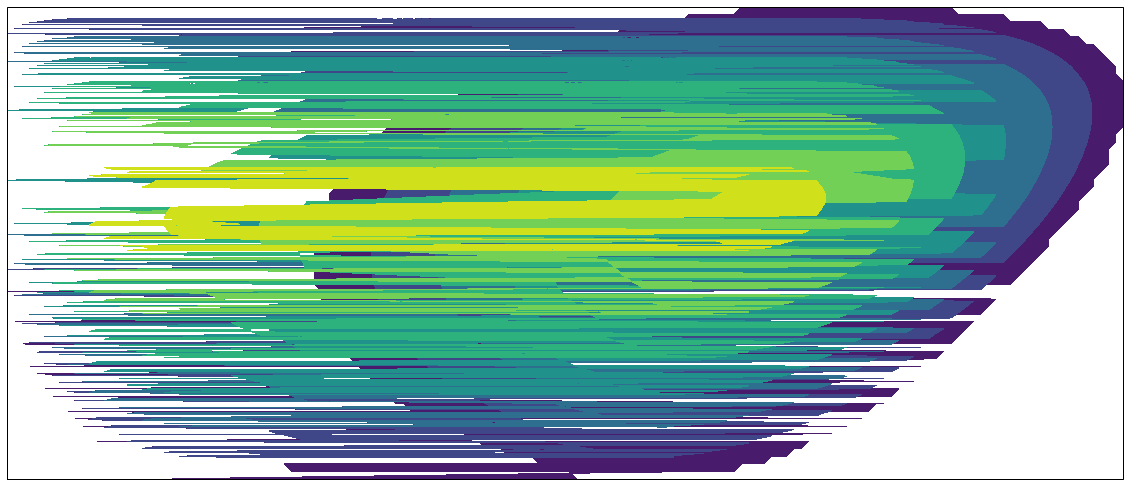

In [58]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(20, 10))
ax.contourf(dataDJF['lon'].values, dataDJF['lat'].values, dataDJF.msl)

In [57]:
djf = nb.lammoc_plot(dataDJF,'ERA-5')
djf.plot()

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 150)
Coordinates:
  * lat      (lat) float64 -22.25 -22.5 -22.75 -23.0 ... -37.5 -37.75 -38.0
  * lon      (lon) float64 -15.75 -15.5 -15.25 -15.0 ... 10.5 10.75 11.0 11.25
Data variables:
    msl      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [277]:
latlist = []
lonlist = []
for lat in DataF.msl.sel(season='DJF'):
    if 
        latlist.append(lat)
        for lon in lat:
            countLon+=1

In [28]:
lista = []
for lat in DataF.msl.sel(season='DJF'):
    for lon in lat:
        if lon.values > 0:
            lista.append([lon.lat.values, lon.lon.values])

<ipython-input-28-1cd0b3e2825b>:4: RuntimeWarning: invalid value encountered in greater
  if lon.values > 0:


In [48]:
menorLat = 0
maiorLat = -100
menorLon = 0
maiorLon = -100
for cada in lista:
    if cada[0] <= menorLat:
        menorLat = cada[0]
    if cada[0] >= maiorLat:
        maiorLat = cada[0]
    if cada[1] <= menorLon:
        menorLon = cada[1]
    if cada[1] >= maiorLon:
        maiorLon = cada[1]

In [65]:
lista[lista[0]==min(lista)]

[array(-38.), array(-5.75)]

In [49]:
menorLat

array(-38.)

In [50]:
menorLon

array(-26.)

In [52]:
maiorLat

array(-22.25)

In [51]:
maiorLon

array(11.25)

In [82]:
for cada in lista:
    if lista[:][0] == -22.25:
        print (lista)

In [ ]:
if lista[:][0]

In [73]:
lista

[[array(-38.), array(-6.)],
 [array(-38.), array(-5.75)],
 [array(-38.), array(-5.5)],
 [array(-38.), array(-5.25)],
 [array(-38.), array(-5.)],
 [array(-38.), array(-4.75)],
 [array(-38.), array(-4.5)],
 [array(-38.), array(-4.25)],
 [array(-38.), array(-4.)],
 [array(-38.), array(-3.75)],
 [array(-38.), array(-3.5)],
 [array(-38.), array(-3.25)],
 [array(-38.), array(-3.)],
 [array(-38.), array(-2.75)],
 [array(-38.), array(-2.5)],
 [array(-38.), array(-2.25)],
 [array(-38.), array(-2.)],
 [array(-38.), array(-1.75)],
 [array(-38.), array(-1.5)],
 [array(-38.), array(-1.25)],
 [array(-38.), array(-1.)],
 [array(-38.), array(-0.75)],
 [array(-38.), array(-0.5)],
 [array(-38.), array(-0.25)],
 [array(-38.), array(0.)],
 [array(-38.), array(0.25)],
 [array(-38.), array(0.5)],
 [array(-38.), array(0.75)],
 [array(-38.), array(1.)],
 [array(-38.), array(1.25)],
 [array(-38.), array(1.5)],
 [array(-38.), array(1.75)],
 [array(-38.), array(2.)],
 [array(-38.), array(2.25)],
 [array(-38.), a

In [26]:
lon.lon.values

array(12.)

In [120]:
coordsTup = []
for season in DataF.msl:
    S = season
    for lat in season:
        for lon in lat:
            if lon >=1018:
                LAT = float(cada.lat.values)
                LON = float(cada.lon.values)
                coordsTup.append([LAT,LON])

In [119]:
lon>=1018

<xarray.DataArray 'msl' ()>
array(True)
Coordinates:
    lat      float32 -40.0
    lon      float32 12.0
    season   <U3 'SON'

In [114]:
lat

<xarray.DataArray 'msl' (lon: 217)>
array([1016.0004 , 1016.0046 , 1016.0018 , 1016.00214, 1016.0023 ,
       1016.0035 , 1016.004  , 1016.0011 , 1015.99805, 1015.99866,
       1015.9977 , 1015.9949 , 1015.9945 , 1015.99316, 1015.9915 ,
       1015.9923 , 1015.99115, 1015.9898 , 1015.9922 , 1015.9887 ,
       1015.98645, 1015.99066, 1015.98755, 1015.98737, 1015.9951 ,
       1015.9926 , 1015.99585, 1016.00366, 1016.0017 , 1016.0018 ,
       1016.00165, 1016.     , 1015.99506, 1015.99023, 1015.98334,
       1015.9833 , 1015.9819 , 1015.97845, 1015.9798 , 1015.9805 ,
       1015.9798 , 1015.97864, 1015.98395, 1015.9861 , 1015.98834,
       1015.9912 , 1015.9943 , 1015.9936 , 1015.99536, 1015.9982 ,
       1016.00116, 1016.0031 , 1016.00714, 1016.0113 , 1016.0102 ,
       1016.0148 , 1016.0202 , 1016.023  , 1016.0297 , 1016.03656,
       1016.04395, 1016.05066, 1016.0592 , 1016.0675 , 1016.07806,
       1016.0872 , 1016.09534, 1016.1056 , 1016.11487, 1016.12177,
       1016.1282 , 1016.1418 , 1016.15234, 1016.1617 , 1016.1784 ,
       1016.191  , 1016.20355, 1016.21893, 1016.23254, 1016.2484 ,
       1016.264  , 1016.27814, 1016.29553, 1016.3166 , 1016.33014,
       1016.3496 , 1016.37396, 1016.3883 , 1016.40924, 1016.43256,
       1016.4477 , 1016.4666 , 1016.48694, 1016.506  , 1016.5251 ,
       1016.5458 , 1016.56537, 1016.58765, 1016.6104 , 1016.6319 ,
       1016.65533, 1016.6811 , 1016.70465, 1016.7258 , 1016.74786,
       1016.7726 , 1016.7975 , 1016.82245, 1016.84906, 1016.874  ,
       1016.9029 , 1016.9309 , 1016.9562 , 1016.9847 , 1017.0129 ,
       1017.0365 , 1017.06055, 1017.08887, 1017.1151 , 1017.1416 ,
       1017.1713 , 1017.1982 , 1017.2198 , 1017.2543 , 1017.2831 ,
       1017.30664, 1017.33856, 1017.3689 , 1017.39624, 1017.41876,
       1017.4555 , 1017.4861 , 1017.5137 , 1017.54596, 1017.5752 ,
       1017.60297, 1017.63324, 1017.6656 , 1017.69666, 1017.7249 ,
       1017.755  , 1017.7856 , 1017.81647, 1017.8469 , 1017.87714,
       1017.9074 , 1017.9384 , 1017.97015, 1018.00006, 1018.025  ,
       1018.0551 , 1018.08417, 1018.11145, 1018.141  , 1018.1689 ,
       1018.1938 , 1018.22156, 1018.2489 , 1018.27386, 1018.30005,
       1018.32605, 1018.35004, 1018.3787 , 1018.4016 , 1018.42395,
       1018.4484 , 1018.47144, 1018.4923 , 1018.51276, 1018.5334 ,
       1018.55133, 1018.5684 , 1018.588  , 1018.6039 , 1018.6191 ,
       1018.6376 , 1018.6512 , 1018.66595, 1018.6833 , 1018.6954 ,
       1018.70667, 1018.7164 , 1018.7288 , 1018.73755, 1018.7445 ,
       1018.75366, 1018.7592 , 1018.7653 , 1018.7711 , 1018.7731 ,
       1018.7772 , 1018.7818 , 1018.77997, 1018.78156, 1018.7839 ,
       1018.785  , 1018.7854 , 1018.78546, 1018.7811 , 1018.77924,
       1018.776  , 1018.7705 , 1018.765  , 1018.75903, 1018.7509 ,
       1018.73804, 1018.7266 , 1018.7108 , 1018.6947 , 1018.6707 ,
       1018.6449 , 1018.62524, 1018.5978 , 1018.5683 , 1018.54083,
       1018.50995, 1018.4731 ], dtype=float32)
Coordinates:
    lat      float32 -40.0
  * lon      (lon) float32 -42.0 -41.75 -41.5 -41.25 ... 11.25 11.5 11.75 12.0
    season   <U3 'SON'

In [105]:
teste

<xarray.DataArray 'msl' (lat: 81, lon: 217)>
array([[1016.7171 , 1016.7321 , 1016.63043, ..., 1015.112  , 1015.0104 ,
        1014.92834],
       [1017.0367 , 1017.0538 , 1016.9763 , ..., 1015.2086 , 1015.10223,
        1015.00964],
       [1017.1112 , 1017.04785, 1016.9703 , ..., 1015.30084, 1015.19293,
        1015.09784],
       ...,
       [1016.25275, 1016.25555, 1016.2496 , ..., 1018.9528 , 1018.91473,
        1018.8724 ],
       [1016.1258 , 1016.13025, 1016.1319 , ..., 1018.7551 , 1018.719  ,
        1018.67804],
       [1016.0004 , 1016.0046 , 1016.0018 , ..., 1018.54083, 1018.50995,
        1018.4731 ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -20.0 -20.25 -20.5 -20.75 ... -39.5 -39.75 -40.0
  * lon      (lon) float32 -42.0 -41.75 -41.5 -41.25 ... 11.25 11.5 11.75 12.0
    season   <U3 'SON'

In [18]:
data_season.msl[0][0]

<xarray.DataArray 'msl' (lon: 217)>
array([1014.35516, 1014.30853, 1014.15924, 1014.39496, 1014.5697 ,
       1014.53796, 1014.0173 , 1013.33655, 1013.26776, 1013.3231 ,
       1013.39594, 1013.4655 , 1013.5537 , 1013.62976, 1013.70605,
       1013.7893 , 1013.8608 , 1013.94006, 1014.0134 , 1014.08856,
       1014.16315, 1014.23737, 1014.3062 , 1014.3857 , 1014.44885,
       1014.5245 , 1014.58496, 1014.6526 , 1014.7143 , 1014.7768 ,
       1014.84204, 1014.8987 , 1014.9633 , 1015.01245, 1015.0778 ,
       1015.12897, 1015.1854 , 1015.24207, 1015.29266, 1015.34485,
       1015.4008 , 1015.43774, 1015.50745, 1015.536  , 1015.5964 ,
       1015.6383 , 1015.684  , 1015.7308 , 1015.7748 , 1015.8183 ,
       1015.8629 , 1015.9027 , 1015.94556, 1015.98285, 1016.02454,
       1016.0593 , 1016.0978 , 1016.1356 , 1016.16437, 1016.2125 ,
       1016.23505, 1016.2777 , 1016.3066 , 1016.3387 , 1016.3737 ,
       1016.40356, 1016.4328 , 1016.4647 , 1016.48627, 1016.52057,
       1016.54285, 1016.57336, 1016.59674, 1016.62213, 1016.6461 ,
       1016.67   , 1016.6943 , 1016.7172 , 1016.74274, 1016.7606 ,
       1016.78613, 1016.8044 , 1016.8225 , 1016.84283, 1016.86206,
       1016.87946, 1016.90094, 1016.91296, 1016.9352 , 1016.94904,
       1016.96643, 1016.9828 , 1016.9947 , 1017.009  , 1017.02277,
       1017.03143, 1017.04517, 1017.0544 , 1017.0642 , 1017.07465,
       1017.08484, 1017.0936 , 1017.1022 , 1017.10846, 1017.1202 ,
       1017.12366, 1017.1316 , 1017.13934, 1017.142  , 1017.1471 ,
       1017.15045, 1017.15063, 1017.1533 , 1017.1542 , 1017.1585 ,
       1017.1582 , 1017.1608 , 1017.1573 , 1017.1542 , 1017.1506 ,
       1017.14545, 1017.1418 , 1017.13806, 1017.13495, 1017.13104,
       1017.1235 , 1017.11707, 1017.1075 , 1017.0967 , 1017.08685,
       1017.07446, 1017.06714, 1017.0528 , 1017.0416 , 1017.02704,
       1017.0128 , 1016.9978 , 1016.98126, 1016.9637 , 1016.947  ,
       1016.9264 , 1016.90796, 1016.883  , 1016.8639 , 1016.8367 ,
       1016.8141 , 1016.78845, 1016.76117, 1016.7356 , 1016.71204,
       1016.6798 , 1016.65436, 1016.626  , 1016.59283, 1016.5624 ,
       1016.5293 , 1016.4943 , 1016.45935, 1016.42554, 1016.38196,
       1016.3493 , 1016.3068 , 1016.26495, 1016.2247 , 1016.1799 ,
       1016.1337 , 1016.0887 , 1016.04645, 1015.99634, 1015.94806,
       1015.8996 , 1015.8475 , 1015.7988 , 1015.7468 , 1015.6915 ,
       1015.6379 , 1015.57776, 1015.51886, 1015.4598 , 1015.3964 ,
       1015.33264, 1015.26874, 1015.2022 , 1015.1337 , 1015.06757,
       1014.9939 , 1014.9228 , 1014.8568 , 1014.77985, 1014.7086 ,
       1014.6341 , 1014.5548 , 1014.47504, 1014.3961 , 1014.31287,
       1014.2318 , 1014.15216, 1014.0672 , 1013.9856 , 1013.901  ,
       1013.81586, 1013.7274 , 1013.63983, 1013.55585, 1013.4657 ,
       1013.3775 , 1013.29376, 1013.2002 , 1013.1122 , 1013.0258 ,
       1012.93555, 1012.8592 , 1012.7736 , 1012.69977, 1012.6249 ,
       1012.5516 , 1012.489  ], dtype=float32)
Coordinates:
    lat      float32 -20.0
  * lon      (lon) float32 -42.0 -41.75 -41.5 -41.25 ... 11.25 11.5 11.75 12.0
    season   <U3 'DJF'